In [1]:
%matplotlib inline


# Behavioral cloning with PyTorch


We present here how to perform behavioral cloning on a Minari dataset using [PyTorch](https://pytorch.org/).
We will start generating the dataset of the expert policy for the [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment, which is a classic control problem.
The objective is to balance the pole on the cart, and we receive a reward of +1 for each successful timestep.



## Imports
For this tutorial you will need the [RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) library, which you can install with `pip install rl_zoo3`.
Let's then import all the required packages and set the random seed for reproducibility:



In [2]:

import sys
from rl_zoo3.train import train
import os
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from gymnasium import spaces
from stable_baselines3 import PPO
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import minari
from minari import DataCollector

import sys
from rl_zoo3.train import train

torch.manual_seed(42)

/Users/frankcholula/Workspace/school/FRL-playground/.frl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Policy training
Now we can train the expert policy using RL Baselines3 Zoo.
We train a PPO agent on the environment:



In [62]:
sys.argv = [
    "python", 
    "--algo", "ppo",
    "--env", "LunarLanderContinuous-v3",
    "--n-timesteps", "1000000",
    "--track",
    "--wandb-project-name", "FRL",
    "--wandb-entity", "frankcholula",
    "--tensorboard-log", "runs",
    "--device", "cpu",
    "--hyperparams",
    "n_envs:16",
    "n_steps:1024",
    "batch_size:64",
    "n_epochs:4",
    "gamma:0.999",
    "gae_lambda:0.98",
    "ent_coef:0.01"
]

train()

========== LunarLanderContinuous-v3 ==========
Seed: 798920032


wandb: Currently logged in as: tsufanglu (frankcholula) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading hyperparameters from: /Users/frankcholula/Workspace/school/FRL-playground/.frl/lib/python3.10/site-packages/rl_zoo3/hyperparams/ppo.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 64),
             ('ent_coef', 0.01),
             ('gae_lambda', 0.98),
             ('gamma', 0.999),
             ('n_envs', 16),
             ('n_epochs', 4),
             ('n_steps', 1024),
             ('n_timesteps', 1000000.0),
             ('policy', 'MlpPolicy')])
Using 16 environments
Overwriting n_timesteps with n=1000000
Creating test environment
Using cpu device
Log path: logs/ppo/LunarLanderContinuous-v3_6
Logging to runs/LunarLanderContinuous-v3__ppo__798920032__1752777978/LunarLanderContinuous-v3/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | -265     |
| time/              |          |
|    fps             | 22041    |
|    iterations     

BrokenPipeError: [Errno 32] Broken pipe

This will generate a new folder named `log` with the expert policy.



## Dataset generation
Now let's generate the dataset using the [DataCollector](https://minari.farama.org/api/data_collector/) wrapper:




In [3]:
env = DataCollector(gym.make("LunarLander-v3", continuous=True))
path = os.path.abspath('')+ "/logs/ppo/LunarLanderContinuous-v3_5/best_model.zip"
agent = PPO.load(path)

total_episodes = 1_000
for i in tqdm(range(total_episodes)):
    obs, _ = env.reset()
    while True:
        action, _ = agent.predict(obs, deterministic=True)
        obs, rew, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            break

 15%|█▌        | 151/1000 [00:06<00:37, 22.61it/s]


KeyboardInterrupt: 

In [102]:
dataset = env.create_dataset(
    dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1",
    algorithm_name="ppo",
    code_permalink="https://github.com/frankcholula/FRL-playground/blob/main/code/behavioral_cloning.py",
    author="Frank Lu",
    author_email="lu.phrank@gmail.com",
    description="Behavioral cloning dataset for LunarLanderContinuous-v3 using PPO",
    eval_env="LunarLanderContinuous-v3"
)

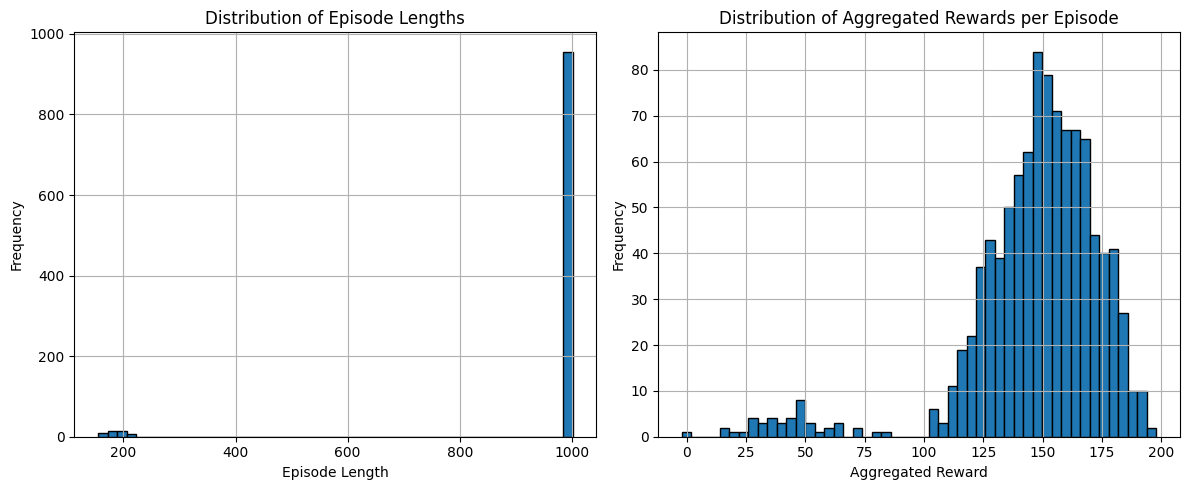

Total number of episodes: 1000
Average episode length: 965.20
Min episode length: 155
Max episode length: 1001
Average aggregated reward: 147.12
Min aggregated reward: -1.96
Max aggregated reward: 197.90


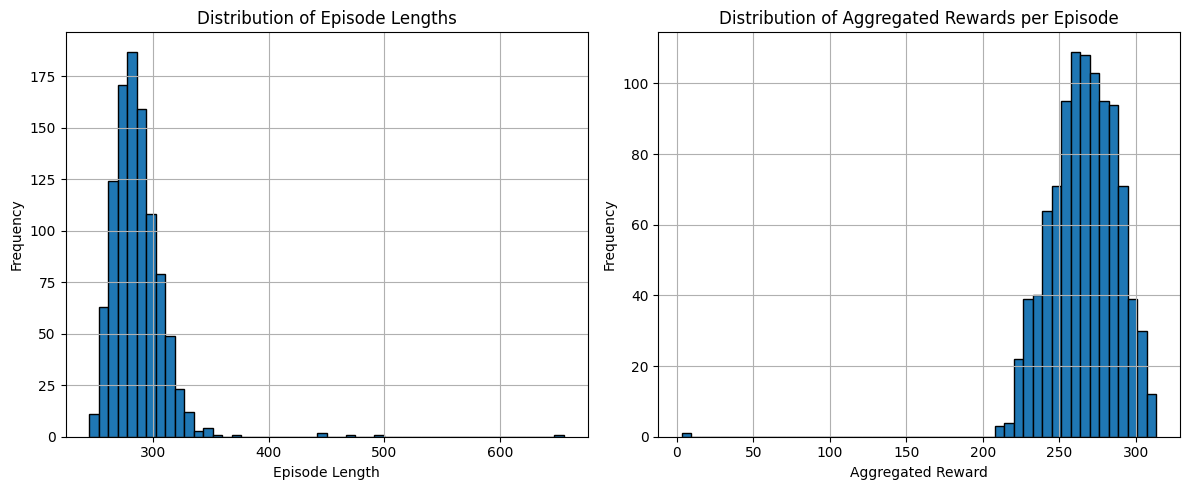

Total number of episodes: 1000
Average episode length: 286.24
Min episode length: 245
Max episode length: 655
Average aggregated reward: 265.91
Min aggregated reward: 3.29
Max aggregated reward: 313.31


In [5]:
import minari
import numpy as np
import matplotlib.pyplot as plt

minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-v1")
minari_dataset_deterministic = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")

def visualize_dataset(dataset):
    episode_lengths = []
    aggregated_rewards = []

    for eps in dataset.episode_indices:
        episode = dataset[eps]
        episode_lengths.append(episode.observations.shape[0])    
        aggregated_rewards.append(np.sum(episode.rewards))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(episode_lengths, bins=50, edgecolor='black')
    plt.title('Distribution of Episode Lengths')
    plt.xlabel('Episode Length')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(aggregated_rewards, bins=50, edgecolor='black')
    plt.title('Distribution of Aggregated Rewards per Episode')
    plt.xlabel('Aggregated Reward')
    plt.ylabel('Frequency')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

    print(f"Total number of episodes: {len(episode_lengths)}")
    print(f"Average episode length: {np.mean(episode_lengths):.2f}")
    print(f"Min episode length: {np.min(episode_lengths)}")
    print(f"Max episode length: {np.max(episode_lengths)}")
    print(f"Average aggregated reward: {np.mean(aggregated_rewards):.2f}")
    print(f"Min aggregated reward: {np.min(aggregated_rewards):.2f}")
    print(f"Max aggregated reward: {np.max(aggregated_rewards):.2f}")
visualize_dataset(minari_dataset)
visualize_dataset(minari_dataset_deterministic)

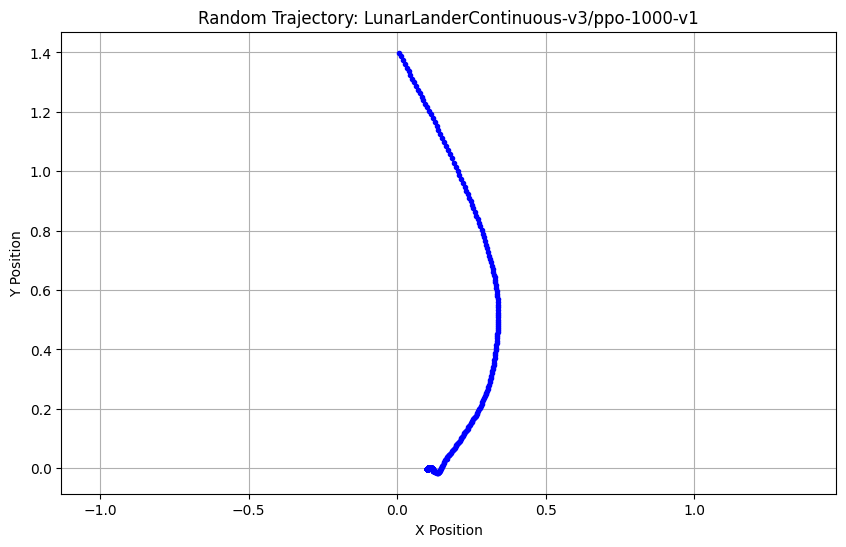

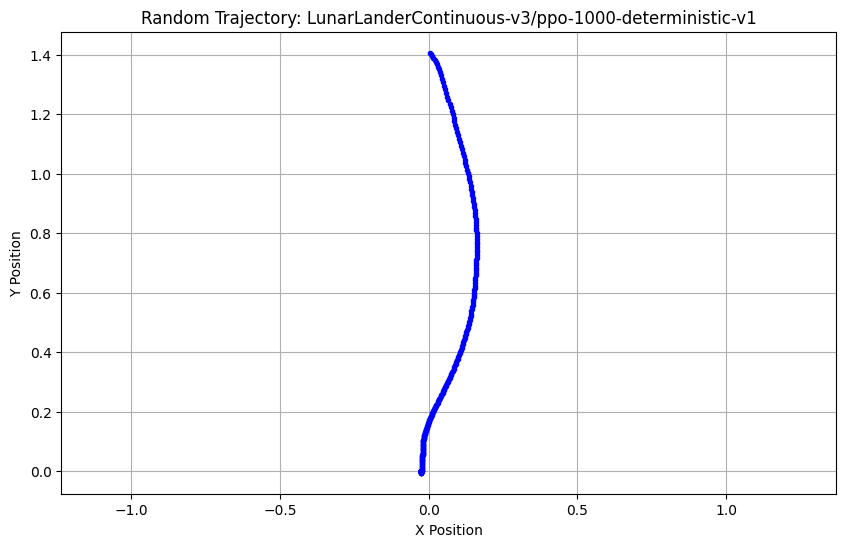

In [15]:
import random
def visualize_observations(dataset):
    """Visualizes a random episode's observations from the dataset."""
    eps = random.choice(dataset.episode_indices)
    episode = dataset[eps]
    observations = episode.observations
    x =  observations[:, 0]  # x position
    y = observations[:, 1]  # y position
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', markersize=3)
    plt.title(f'Random Trajectory: {dataset.spec.dataset_id}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid()
    plt.axis('equal')
    plt.show()

visualize_observations(minari_dataset)
visualize_observations(minari_dataset_deterministic)

In [ ]:
import random
# Sample a random episode from the dataset
# random_episode = minari_dataset.sample_episodes(1)[0]
successful_episodes = minari_dataset.filter_episodes(lambda eps: eps.rewards.sum() > 190)
print(f"Number of successful episodes: {len(successful_episodes)}")
test_episode = random.choice(successful_episodes)
print(test_episode.rewards.sum())

Number of successful episodes: 12
191.70643700096326


Once executing the script, the dataset will be saved on your disk. You can display the list of datasets with ``minari list local`` command.



## Behavioral cloning with PyTorch
Now we can use PyTorch to learn the policy from the offline dataset.
Let's define the policy network:



In [82]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        actions = torch.tanh(self.fc3(x))
        return actions

In this scenario, the output dimension will be two, as previously mentioned. As for the input dimension, it will be four, corresponding to the observation space of ``CartPole-v1``.
Our next step is to load the dataset and set up the training loop. The ``MinariDataset`` is compatible with the PyTorch Dataset API, allowing us to load it directly using [PyTorch DataLoader](https://pytorch.org/docs/stable/data.html).
However, since each episode can have a varying length, we need to pad them.
To achieve this, we can utilize the [collate_fn](https://pytorch.org/docs/stable/data.html#working-with-collate-fn) feature of PyTorch DataLoader. Let's create the ``collate_fn`` function:



In [83]:
def collate_fn(batch):
    return {
        "id": torch.Tensor([x.id for x in batch]),
        "observations": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.observations) for x in batch],
            batch_first=True
        ),
        "actions": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.actions) for x in batch],
            batch_first=True
        ),
        "rewards": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.rewards) for x in batch],
            batch_first=True
        ),
        "terminations": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.terminations) for x in batch],
            batch_first=True
        ),
        "truncations": torch.nn.utils.rnn.pad_sequence(
            [torch.as_tensor(x.truncations) for x in batch],
            batch_first=True
        )
    }

We can now proceed to load the data and create the training loop.
To begin, let's initialize the DataLoader, neural network, optimizer, and loss.



In [115]:
minari_dataset = minari.load_dataset("LunarLanderContinuous-v3/ppo-1000-v1")
# minari_dataset = minari.load_dataset("LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

env = minari_dataset.recover_environment()

observation_space = env.observation_space
action_space = env.action_space

assert isinstance(observation_space, spaces.Box)
assert isinstance(action_space, spaces.Box)

obs_dim = np.prod(observation_space.shape)
action_dim = action_space.shape[0]

policy_net = PolicyNetwork(obs_dim, action_dim)
optimizer = torch.optim.Adam(policy_net.parameters())
loss_fn = nn.MSELoss()

In [116]:
# This is baseline MLP cloning
num_epochs = 32
for epoch in range(num_epochs):
    for batch in dataloader:
        observations = batch["observations"][:, :-1]  # Exclude the last observation
        expert_actions = batch["actions"]
        predictioned_actions = policy_net(observations)
        loss = loss_fn(predictioned_actions, expert_actions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}/{num_epochs}, Loss: {loss.item()}")

Epoch: 0/32, Loss: 0.4157146215438843
Epoch: 1/32, Loss: 0.36255761981010437
Epoch: 2/32, Loss: 0.35032784938812256
Epoch: 3/32, Loss: 0.3372179865837097
Epoch: 4/32, Loss: 0.3390456736087799
Epoch: 5/32, Loss: 0.33294814825057983
Epoch: 6/32, Loss: 0.33280041813850403
Epoch: 7/32, Loss: 0.32822325825691223
Epoch: 8/32, Loss: 0.321440726518631
Epoch: 9/32, Loss: 0.32173997163772583
Epoch: 10/32, Loss: 0.3214046359062195
Epoch: 11/32, Loss: 0.31747952103614807
Epoch: 12/32, Loss: 0.30869296193122864
Epoch: 13/32, Loss: 0.3100595772266388
Epoch: 14/32, Loss: 0.31434571743011475
Epoch: 15/32, Loss: 0.3094603419303894
Epoch: 16/32, Loss: 0.3053094744682312
Epoch: 17/32, Loss: 0.31009531021118164
Epoch: 18/32, Loss: 0.3082921504974365
Epoch: 19/32, Loss: 0.31478333473205566
Epoch: 20/32, Loss: 0.31653299927711487
Epoch: 21/32, Loss: 0.31267449259757996
Epoch: 22/32, Loss: 0.30693909525871277
Epoch: 23/32, Loss: 0.3113649785518646
Epoch: 24/32, Loss: 0.3051842749118805
Epoch: 25/32, Loss: 0.

In [114]:
eval_env = gym.make("LunarLander-v3", continuous=True, render_mode="human")
obs, _ = eval_env.reset()
done = False
accumulated_rew = 0
while not done:
    obs_tensor = torch.Tensor(obs)
    action = policy_net(obs_tensor).detach().numpy()
    obs, rew, ter, tru, _ = eval_env.step(action)
    done = ter or tru
    accumulated_rew += rew
env.close()
print("Accumulated rew: ", accumulated_rew)

Accumulated rew:  298.17075425254234


In [111]:

eval_env = gym.make("LunarLander-v3", continuous=True, render_mode=None)  # disable human render for batch eval
episode_lengths = []
episode_rewards = []

num_episodes = 1000
for _ in range(num_episodes):
    obs, _ = eval_env.reset()
    done = False
    ep_len = 0
    accumulated_rew = 0.0
    
    while not done:
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        action = policy_net(obs_tensor).detach().numpy()
        obs, rew, ter, tru, _ = eval_env.step(action)
        done = ter or tru
        accumulated_rew += rew
        ep_len += 1

    episode_lengths.append(ep_len)
    episode_rewards.append(accumulated_rew)

eval_env.close()

# Convert to NumPy for easier plotting
episode_lengths = np.array(episode_lengths)
episode_rewards = np.array(episode_rewards)

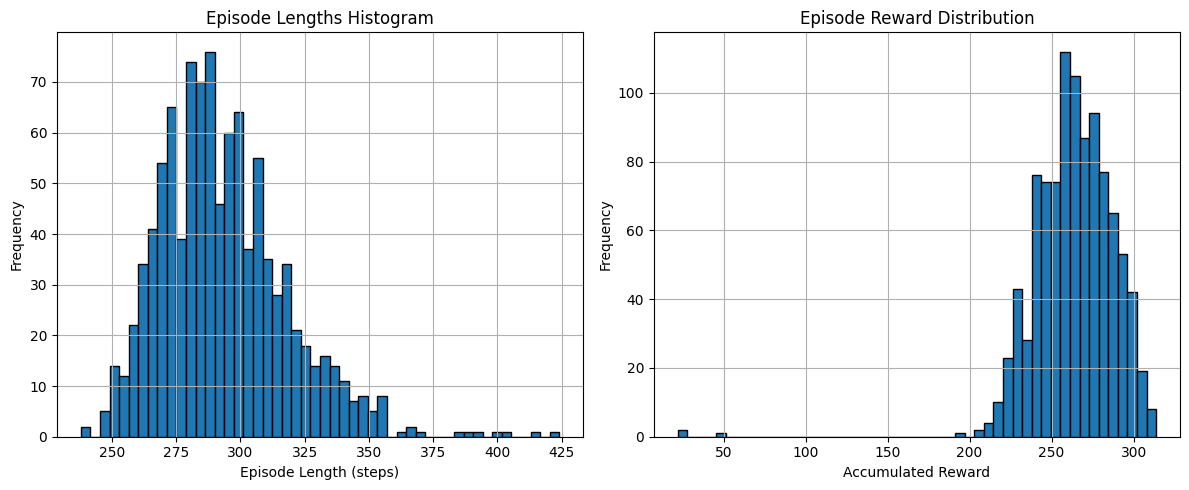

In [112]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(episode_lengths, bins=50, edgecolor='black')
plt.title("Episode Lengths Histogram")
plt.xlabel("Episode Length (steps)")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(episode_rewards, bins=50, edgecolor='black')
plt.title("Episode Reward Distribution")
plt.xlabel("Accumulated Reward")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()